# Noise2Void - 2D Example for RGB Data

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
import rawpy
import numpy as np
from PIL import Image

def load_image(image_path):
    img = Image.open(image_path)

    # Normalize pixel values to [0, 1]
    img = np.array(img) / 255.0
    
    # Add an extra dimension for consistency (if needed)
    if img.ndim == 3:
        img = img[np.newaxis, ...]

    return img
    

def load_dng_image(image_path):

  with rawpy.imread(image_path) as raw:
    rgb = raw.postprocess(use_camera_wb=True, half_size=False, output_color=rawpy.ColorSpace.sRGB)

  # Convert to PIL Image for potential further processing
  img = Image.fromarray(rgb)

  # Normalize pixel values to [0, 1]
  img = np.array(img) / 255.0

  # Add an extra dimension for consistency (if needed)
  if img.ndim == 3:
    img = img[np.newaxis, ...]

  return img


# Download Example Data
Original clean photograph is by Eric Fredericks published on Flickr under CC license: https://creativecommons.org/licenses/by-sa/2.0/.
Our modified noisy version is under the same license.

In [55]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/RGB.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://download.fht.org/jug/n2v/RGB.zip', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [13]:
path = "C:/Users/janni/Desktop/ETH/BT/Messungen/Huawei P20/iso1600expo5/6DB.dng"
path = "C:/Users/janni/Desktop/ETH/BT/Messungen/Huawei P20/lowest/8D_final/images/IMG_20240817_172524.dng"
path = "C:/Users/janni/Desktop/ETH/BT/Messungen/Arducam 3MP final/4D/MEGA_3MP_JPEG_2048x1536_8.JPG"
img = load_image(path)

In [14]:
imgs = np.rot90(img, 3)
imgs = [img]

print(len(imgs))
print(imgs[0].shape)

1
(1, 1536, 2048, 3)


# Training Data Preparation
For training, we will load __one__ low-SNR RGB image and use the <code>N2V_DataGenerator</code> to extract non-overlapping patches.

In [15]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

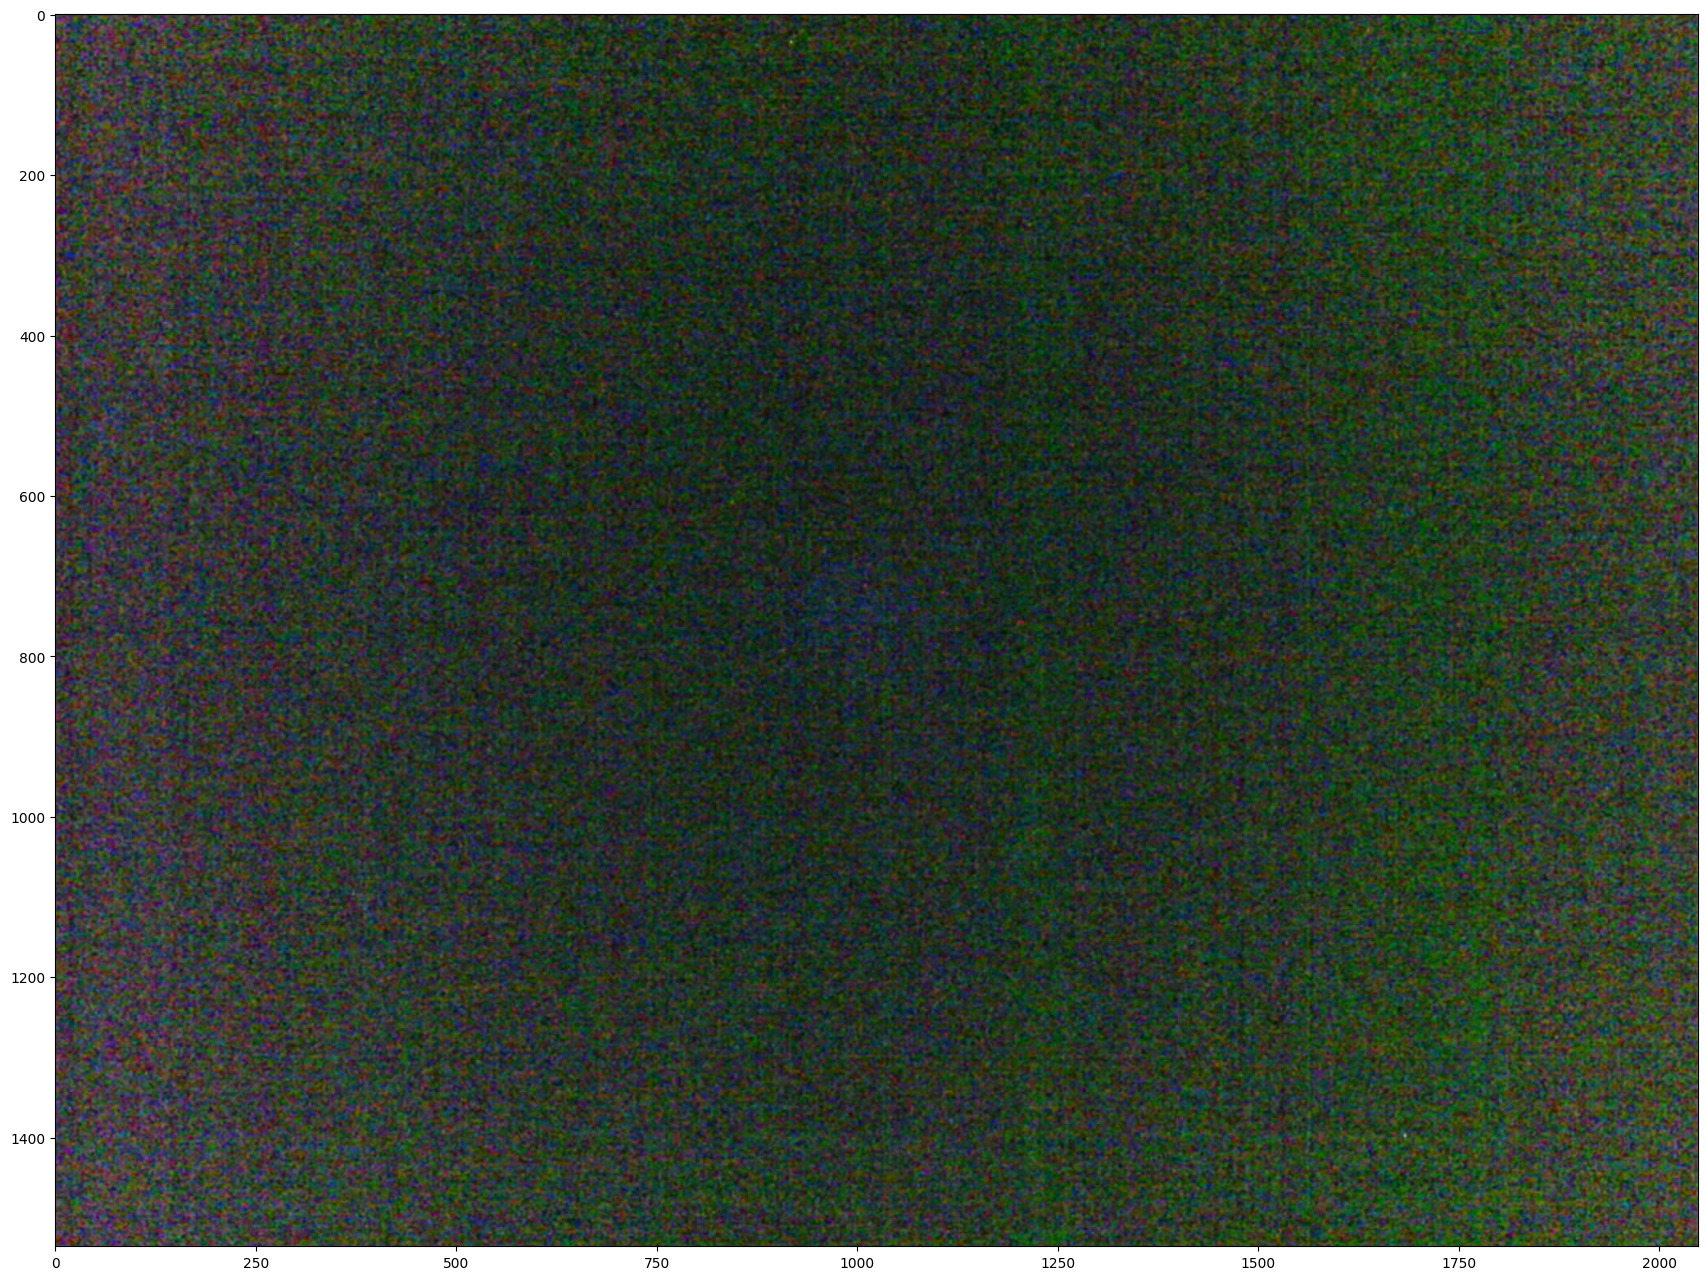

In [16]:
# Let's look at the image.
# We have to remove the added extra dimension to display it as 2D image.
plt.figure(figsize=(32,16))
plt.imshow(imgs[0][0])
plt.show()

In [17]:
# Next we extract patches for training and validation.
# The parameter 'shape' defines the size of these patches.
patch_shape=(64,64)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)

Generated patches: (6144, 64, 64, 3)


In [18]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
X = patches[:5000]
X_val = patches[5000:]

In [19]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

Signature:
datagen.generate_patches_from_list(
    data,
    num_patches_per_img=None,
    shape=(256, 256),
    augment=True,
    shuffle=False,
)
Docstring:
Extracts patches from 'list_data', which is a list of images, and returns them in a 'numpy-array'. The images
can have different dimensionality.

Parameters
----------
data                : list(array(float))
                      List of images with dimensions 'SZYXC' or 'SYXC'
num_patches_per_img : int, optional(default=None)
                      Number of patches to extract per image. If 'None', as many patches as fit i nto the
                      dimensions are extracted.
shape               : tuple(int), optional(default=(256, 256))
                      Shape of the extracted patches.
augment             : bool, optional(default=True)
                      Rotate the patches in XY-Plane and flip them along X-Axis. This only works if the patches are square in XY.
shuffle             : bool, optional(default=False)
       

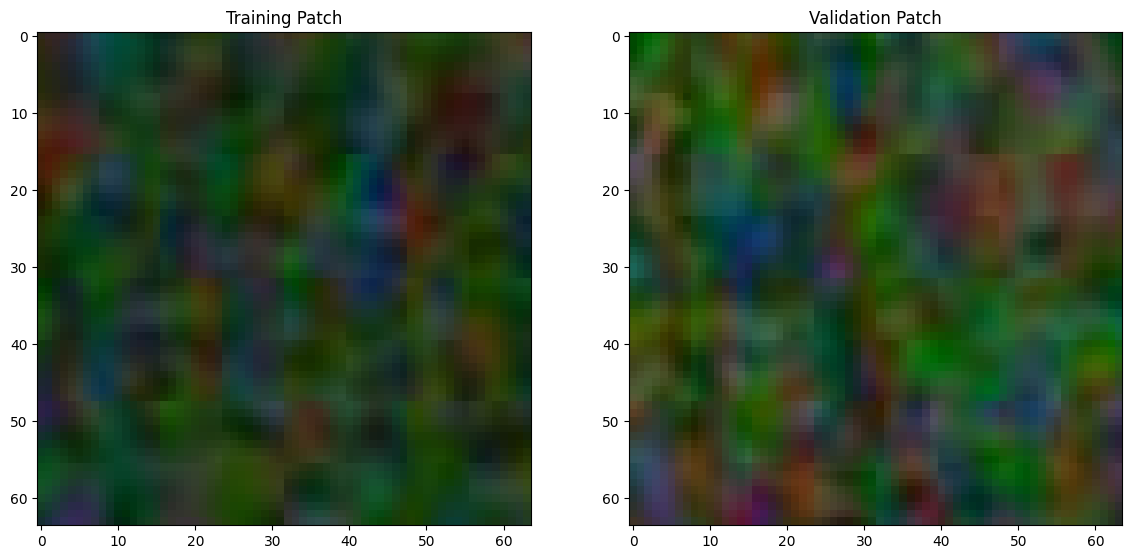

In [20]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...])
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...])
plt.title('Validation Patch');

# Configure

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
Compared to working with single channel data, we also recommend to use a deeper network with more feature channels.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).   

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the `single_net_per_channel` option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough. <br/>
__Note:__ Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.<br/>
But for RGB images we can turn this option off. 

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 25. <br>For better results we suggest 100 to 200 <code>train_epochs</code>.

In [27]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch 
# is shown once per epoch. 
config = N2VConfig(X, unet_kern_size=3, 
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/128), train_epochs=15, train_loss='mse', 
                   batch_norm=True, train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['0.16528300340839486',
  '0.21732047774969424',
  '0.16214126838235302'],
 'stds': ['0.07728062616521932',
  '0.062315390886614974',
  '0.08476194780307213'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 3,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 3),
 'train_loss': 'mse',
 'train_epochs': 15,
 'train_steps_per_epoch': 39,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [28]:
# a name used to identify the model --> change this to something sensible!
model_name = 'n2v_arducam_3MP'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

C:\Users\janni\Desktop\ETH\BT\code\N2V\n2v\n2v\models\n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: C:\Users\janni\Desktop\ETH\BT\code\N2V\n2v\examples\2D\denoising2D_RGB\models\n2v_arducam_3MP
  warnings.warn(


# Training

Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard in a terminal from the current working directory with tensorboard --logdir=. Then connect to http://localhost:6006/ with your browser.

In [29]:
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████████████████████████████████████████████| 1144/1144 [00:02<00:00, 492.68it/s]


Epoch 1/15
39/39 [==============================] - 691s 17s/step - loss: 0.2902 - n2v_mse: 0.2902 - n2v_abs: 0.3772 - val_loss: 0.5238 - val_n2v_mse: 0.5242 - val_n2v_abs: 0.5747 - lr: 4.0000e-04
Epoch 2/15
39/39 [==============================] - 678s 17s/step - loss: 0.0700 - n2v_mse: 0.0700 - n2v_abs: 0.1976 - val_loss: 0.3927 - val_n2v_mse: 0.3930 - val_n2v_abs: 0.4955 - lr: 4.0000e-04
Epoch 3/15
39/39 [==============================] - 503s 13s/step - loss: 0.0510 - n2v_mse: 0.0510 - n2v_abs: 0.1683 - val_loss: 0.3082 - val_n2v_mse: 0.3085 - val_n2v_abs: 0.4396 - lr: 4.0000e-04
Epoch 4/15
39/39 [==============================] - 501s 13s/step - loss: 0.0400 - n2v_mse: 0.0400 - n2v_abs: 0.1490 - val_loss: 0.2279 - val_n2v_mse: 0.2281 - val_n2v_abs: 0.3794 - lr: 4.0000e-04
Epoch 5/15
39/39 [==============================] - 499s 13s/step - loss: 0.0338 - n2v_mse: 0.0338 - n2v_abs: 0.1367 - val_loss: 0.1755 - val_n2v_mse: 0.1756 - val_n2v_abs: 0.3319 - lr: 4.0000e-04
Epoch 6/15
39/3

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


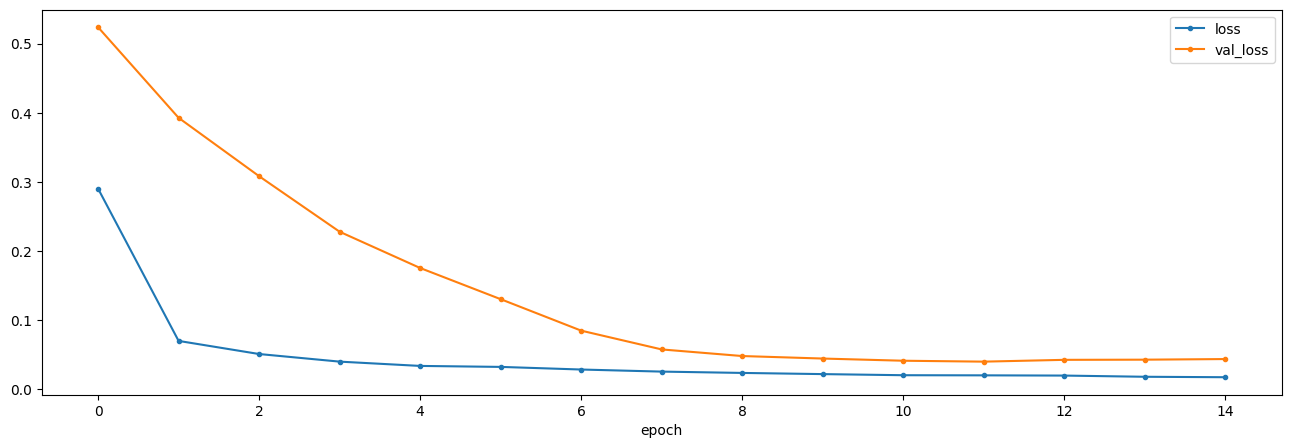

In [30]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model in BioImage ModelZoo Format
See https://imagej.net/N2V#Prediction for details.

In [20]:
pip install bioimageio.core


Note: you may need to restart the kernel to use updated packages.


In [31]:
model.export_TF(name='Noise2Void - Arducam 3MP', 
                description='This is the 2D Noise2Void example trained on RGB data in python.', 
                authors=["Tim-Oliver Buchholz", "Alexander Krull", "Florian Jug"],
                test_img=X_val[0], axes='YXC',
                patch_shape=patch_shape)

1/1 [==============================] - 1s 561ms/step
INFO:tensorflow:Assets written to: C:\Users\janni\Desktop\ETH\BT\code\N2V\n2v\examples\2D\denoising2D_RGB\models\n2v_arducam_3MP\tf_model\assets


INFO:tensorflow:Assets written to: C:\Users\janni\Desktop\ETH\BT\code\N2V\n2v\examples\2D\denoising2D_RGB\models\n2v_arducam_3MP\tf_model\assets


ModuleNotFoundError: No module named 'bioimageio.core.build_spec'

In [ ]:
model.save('C:/Users/janni/Desktop/ETH/BT/code/N2V/n2v/examples/2D/denoising2D_RGB/models')